<a href="https://colab.research.google.com/github/rodrigoprieto/crypto_panel/blob/master/OI_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejecutar primero la siguiente celda para verificar que NO estámos conectandonos a una máquina de 'US', dado que Binance no permite conectarse via API desde United States.

In [2]:
!curl ipinfo.io

{
  "ip": "35.204.93.96",
  "hostname": "96.93.204.35.bc.googleusercontent.com",
  "city": "Groningen",
  "region": "Groningen",
  "country": "NL",
  "loc": "53.2253,6.5813",
  "org": "AS396982 Google LLC",
  "postal": "9713",
  "timezone": "Europe/Amsterdam",
  "readme": "https://ipinfo.io/missingauth"
}

Instalamos la API de Binance

In [3]:
!pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.6 MB/s eta 0:00:00


Ahora instalamos la libreria ta (tiene varios indicadores)

In [4]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=b6c97ec0cba560b0e092d9d6a3e73fcc3338f84277d5f2d8dfe9e053355d5fb3
  Stored in directory: /root/.cache/pip/wheels/6a/76/03/7f785aaa50b9c6ec7e3fd105a62c1b2c45a034512d51e024a9
Successfully built ta


Importamos las librerias que vamos a usar

In [5]:
from matplotlib import colors
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta.volatility
import ta.volume
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
import matplotlib.cm as cm
from datetime import datetime, date, timezone, timedelta
from binance.client import *

Vamos a abrir la conexión con Binance API.

Si te da un error como el siguiente: 


> google colab BinanceAPIException: APIError(code=0): Service unavailable from a restricted location according to 'b. Eligibility'

Significa que estás conectado desde un servidor de un país no autorizado por Binance API. Te recomiendo que vuelvas a reconectarte al servidor. Recuerda que la primera celda te permite saber si estás conectandote desde qué pais.

In [7]:
client = Client()

Creamos una función para bajar las velas utilizando el método get_historical_klines()

In [8]:
def fetch_klines(keep_last):
  klines = client.get_historical_klines(symbol, timeframe, limit=limit)
  df = pd.DataFrame(klines)
  df = df.iloc[:,0:6]
  df.columns = ['Timestamp','Open','High','Low','Close','Volume']
  df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='ms')
  df.set_index('Timestamp',inplace=True)
  df = df.astype(float)
  if not keep_last:
    df.drop(df.tail(1).index, inplace=True)  # drop last row
  return df


Creamos una función para bajar el OpenInterest llamando a futures_open_interest_hist()

In [9]:
def fetch_openinterest():
  oi = client.futures_open_interest_hist(symbol=symbol,period=timeframe,limit=limit)
  df = pd.DataFrame(oi)
  if df.empty:
    raise Exception('Open Interest is empty')
  df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')
  df.set_index('timestamp',inplace=True)
  df.drop(columns=['symbol'],inplace=True)
  df = df.astype(float)
  return df

Creamos una función para obtener la cantidad de decimales de precisión que nos retorna Binance para el par en cuestión. Ej: para BTCUSD es 2. Pero para otras altcoins a veces es 4 o más.

In [10]:
def get_decimal_rounding(df):
    try:
        decimals = len(str(df.head(1)['Close'].values[0]).split('.')[1])
    except:
        decimals = 0
    return decimals

Seteamos algunas variables básicas: el simbolo (BTCUSDT), el timeframe y el limite de velas que queremos obtener.

In [26]:
symbol = 'XRPUSDT'
timeframe = '1h'
limit = 500

Obtenemos las velas (klines) del exchange segun las variables configuradas

In [27]:
df = fetch_klines(False)

Obtenemos el Open Interest para el mismo par

In [28]:
df_oi = fetch_openinterest()

Unimos el dataframe con las klines y el Open Interest

In [29]:
df = df.join(df_oi)

Borramos las celdas que tienen NA

In [30]:
df.dropna(inplace=True)

Imprimimos el dataframe para ver su contenido

In [31]:
df

,Open,High,Low,Close,Volume,sumOpenInterest,sumOpenInterestValue
Timestamp,,,,,,,
2023-02-21 05:00:00,0.3958,0.3987,0.3956,0.3984,13280523.0,331442184.4,1.311646e+08
2023-02-21 06:00:00,0.3984,0.4007,0.3974,0.4007,14926400.0,330315112.6,1.315315e+08
2023-02-21 07:00:00,0.4006,0.4007,0.3976,0.3997,18632437.0,333153269.3,1.334428e+08
2023-02-21 08:00:00,0.3997,0.4025,0.3904,0.3933,44356099.0,333486509.0,1.332555e+08
2023-02-21 09:00:00,0.3933,0.3949,0.3906,0.3925,24199801.0,324158627.0,1.274865e+08
...,...,...,...,...,...,...,...
2023-03-13 19:00:00,0.3727,0.3735,0.3707,0.3717,13699585.0,336449314.4,1.253610e+08
2023-03-13 20:00:00,0.3717,0.3725,0.3696,0.3715,12552801.0,333799990.5,1.239867e+08
2023-03-13 21:00:00,0.3716,0.3730,0.3713,0.3720,8076603.0,331336654.5,1.230253e+08


Obtenemos los decimales de precisión para el simbolo seleccionado

In [32]:
decimal_rounding = get_decimal_rounding(df)

In [33]:
print("Para imprimir los precios vamos a necesitar {} decimales para el par {}".format(decimal_rounding, symbol))

Para imprimir los precios vamos a necesitar 4 decimales para el par XRPUSDT


Hacemos algunos calculos básicos con indicadores, y los agregamos como columnas nuevas en el dataframe. 

In [34]:
volume_sma_ratio = 1.6
# Para calcular la media del volumen considerando N períodos hacia atras
volume_sma_period = 20
# Para calcular el promedio del Open Interest considerando n períodos hacia atras.
openinterest_sma_period = 20
# Factor de multiplicación de la stdev de la media movil para considerar OI anormal
openinterest_std_period = 1.5
# Condicion 1 para alerta de open interest
open_interest_million_threshold = 3000000
# Condicion 2 para alerta de open interest (1% = 0.01)
open_interest_percentage_threshold = 0.1
atr_period = 14
atr_breakout_multiplier = 1.6
dc_period = 14
bb_period = 20
bb_stdev = 2
kc_period = 20
kc_atr_period = 10


# Agregamos una media de volumen
df['VolumeMean'] = df.Volume.rolling(volume_sma_period).mean()
# Calculamos cual seria un volumen anormal multiplicando la media por un ratio
df['AbnormalVolume'] = np.multiply(df['VolumeMean'], volume_sma_ratio)
# Verificamos si tenemos volumen anormal
df['HasAbnormalVolume'] = np.greater(df['Volume'], df['AbnormalVolume'])

# Bollinger bands
df['bb_hband'] = ta.volatility.bollinger_hband(df['Close'], bb_period, bb_stdev)
df['bb_lband'] = ta.volatility.bollinger_lband(df['Close'], bb_period, bb_stdev)

# Keltner Channels
df['kc_hband'] = ta.volatility.keltner_channel_hband(df['High'],
                                                      df['Low'],
                                                      df['Close'],
                                                      kc_period,
                                                      kc_atr_period)
df['kc_lband'] = ta.volatility.keltner_channel_lband(df['High'],
                                                      df['Low'],
                                                      df['Close'],
                                                      kc_period,
                                                      kc_atr_period)
# Calculamos los momentos donde ambos extremos de las Bollinger Bands están dentro del Keltner Channel
df['bb_inside_kc'] = np.where(((df['bb_hband'] < df['kc_hband']) & (df['bb_lband'] > df['kc_lband'])), True, False)

# Calculamos el True range (1 vela)
df['TrueRange'] = ta.volatility.AverageTrueRange(high=df['High'], 
                                                 low=df['Low'], 
                                                 close=df['Close'],
                                                 window=1).average_true_range()
# Calculamos el True range en un periodo definido por atr_period
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], 
                                           low=df['Low'], 
                                           close=df['Close'],
                                           window=atr_period).average_true_range()
# En los casos que no tenemos el ATR, lo completamos con el True Range
df['ATRStandard'] = df['ATR'].fillna(df['TrueRange'])  # Estandarizamos el ATR al TR

# Calculamos promedio del OI
df['openInterestMean'] = df.sumOpenInterest.rolling(openinterest_sma_period).mean()
# Rellenamos con zeros las columnas donde no tenemos data
df['openInterestMean'] = df['openInterestMean'].fillna(0)
# Calculamos el pct_change entre cada vela respecto a su anterior. 
df['openInterestChange'] = df['sumOpenInterest'].pct_change(periods=1, limit=2)
# Calculamos la diferencia en millones de USD en el OI entre una vela y su anterior.
df['openInterestValueDiff'] = df['sumOpenInterestValue'].diff()
# Calculamos si el open interest está por encima de la media y definimos Rising (creciendo) en True cuando sucede de lo contrario False.
df['openInterestRising'] = np.greater_equal(df['sumOpenInterest'], df['openInterestMean'])
# Calculamos la diferencia en el OI (coin margined) de una vela y su anterior.
df['openInterestDiff'] = df['sumOpenInterest'].diff(periods=1)
# Calculamos señales de OI: el pct_change > open_interest_percentage_threshold OR la diferencia en el OI es > open_interest_million_threshold millones
df['openInterestSignal'] = (df['openInterestChange'].ge(open_interest_percentage_threshold) | 
                            (df['openInterestValueDiff'].gt(open_interest_million_threshold)))
# Calculamos desviacion estandard del OI
df['openInterestStd'] = df['sumOpenInterest'].rolling(openinterest_sma_period).std()  # standard deviation
# Calculamos cuando el OI es superior a openinterest_std_period la desviación estandard (anormal)
df['openInterestAbnormal'] = np.greater(df['sumOpenInterest'], df['openInterestMean']+np.multiply(openinterest_std_period,df['openInterestStd'])) | \
                                    np.less_equal(df['sumOpenInterest'], (df['openInterestMean'] -
                                        np.multiply(openinterest_std_period, df['openInterestStd'])))

# -------------------------------------------------
# PRICE CONSOLIDATION & BREAKOUT
# -------------------------------------------------

# Calculamos la CONSOLIDACIÓN DEL PRECIO, para eso necesitamos un donchian channel
dc_upper = ta.volatility.donchian_channel_hband(high=df['High'],
                                                low=df['Low'],
                                                close=df['Close'],
                                                window=dc_period)
dc_middle = ta.volatility.donchian_channel_mband(high=df['High'],
                                                  low=df['Low'],
                                                  close=df['Close'],
                                                  window=dc_period)
dc_lower = ta.volatility.donchian_channel_lband(high=df['High'],
                                                low=df['Low'],
                                                close=df['Close'],
                                                window=dc_period)
if dc_upper is not None and dc_lower is not None and dc_middle is not None:
  # dc = [dc_lower,dc_middle,dc_upper]
  df['DC_UPPER'] = dc_upper
  df['DC_MIDDLE'] = dc_middle
  df['DC_LOWER'] = dc_lower
  df['DC_DIFF'] = np.subtract(df['DC_UPPER'], df['DC_LOWER'])
else:
  # Inicializamos las columnas vacias en el caso que no tengamos la cantidad de perídos para tener un DC
  df[["DC_LOWER", "DC_MIDDLE", "DC_UPPER", "DC_DIFF"]] = np.nan

# Definimos un Breakout a cuando el precio rompe el Donchian Channel con volumen anormal
# y además el True range es > a un múltiplo del atr_breakout_multiplier
df['Breakout'] = (((df['Close'] > df['DC_UPPER'].shift(1)) | (df['Close'] < df['DC_LOWER'].shift(1))) &
                  (df['HasAbnormalVolume']) &
                  np.greater_equal(df['TrueRange'], np.multiply(df['ATRStandard'], atr_breakout_multiplier)))
# Definimos la dirección del breakout
df['BreakoutUpside'] = ((df['Close'] > df['DC_UPPER'].shift(1)) & (df['Breakout']))
# Definimos el marker para luego plotear
df['Marker'] = np.where((df['BreakoutUpside']), '^', 'v')

# Señales de consolidación de precios donde las BB se encontraban dentro del Keltner channel,
# dentro de los Donchian Channel, con bajo volumen (no anormal) y open interest creciente.
# TODO: optimizar ésto
df['PriceConsolidation'] = np.where((df['bb_inside_kc']) &
                                    (np.less_equal(df['Close'], df['DC_UPPER']) &
                                      np.greater_equal(df['Close'], df['DC_LOWER'])) &
                                    (~df['HasAbnormalVolume']) &
                                    (df['openInterestRising']), True, False)                            



Generamos un recorte del dataframe con las velas donde tenemos Open Interest Anormal, o bien una señal en el OI

In [35]:
filtered = df[(df['openInterestAbnormal']) | (df['openInterestSignal'])]

Generamos un recorte del dataframe con las velas donde tenemos Breakout y señal en el Open Interest.

In [36]:
signals = df[(df['Breakout']) & (
                        (df['openInterestSignal']) |
                        (df['openInterestSignal'].shift(1)) |
                        (df['openInterestAbnormal']) |
                        (df['openInterestAbnormal']).shift(1))]

Imprimimos las señales de la confluencia de aquellas filas que tenemos Breakout + OI Signal o OI anormal

In [37]:
signals

,Open,High,Low,Close,Volume,sumOpenInterest,sumOpenInterestValue,VolumeMean,AbnormalVolume,HasAbnormalVolume,...,openInterestStd,openInterestAbnormal,DC_UPPER,DC_MIDDLE,DC_LOWER,DC_DIFF,Breakout,BreakoutUpside,Marker,PriceConsolidation
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-23 11:00:00,0.3958,0.3960,0.3880,0.3896,30632721.0,319277752.1,1.263653e+08,14522907.65,23236652.24,True,...,5.233436e+06,True,0.3979,0.39295,0.3880,0.0099,True,False,v,False
2023-02-24 15:00:00,0.3851,0.3853,0.3786,0.3816,46093255.0,327120686.8,1.260098e+08,12590670.90,20145073.44,True,...,3.252580e+06,True,0.3908,0.38470,0.3786,0.0122,True,False,v,False
2023-02-24 16:00:00,0.3815,0.3816,0.3734,0.3754,48727070.0,328002108.1,1.250789e+08,14676068.65,23481709.84,True,...,3.588209e+06,True,0.3908,0.38210,0.3734,0.0174,True,False,v,False
2023-03-06 01:00:00,0.3691,0.3692,0.3623,0.3626,26063507.0,326287466.7,1.203022e+08,8142809.25,13028494.80,True,...,3.758900e+06,True,0.3726,0.36745,0.3623,0.0103,True,False,v,False
2023-03-07 14:00:00,0.3730,0.3784,0.3719,0.3762,34826989.0,336429698.0,1.254723e+08,19381792.95,31010868.72,True,...,6.082066e+06,True,0.3784,0.37265,0.3669,0.0115,True,True,^,False
2023-03-07 15:00:00,0.3762,0.3827,0.3713,0.3787,80775362.0,345549609.7,1.299490e+08,22323427.95,35717484.72,True,...,7.803124e+06,True,0.3827,0.37480,0.3669,0.0158,True,True,^,False
2023-03-08 13:00:00,0.3915,0.4018,0.3914,0.3953,93374260.0,451685002.7,1.767985e+08,26954137.25,43126619.60,True,...,2.168298e+07,True,0.4018,0.38705,0.3723,0.0295,True,True,^,False
2023-03-09 19:00:00,0.3872,0.3873,0.3763,0.3788,55967457.0,416259431.8,1.611335e+08,24902898.80,39844638.08,True,...,9.486716e+06,True,0.3976,0.38695,0.3763,0.0213,True,False,v,False
2023-03-09 20:00:00,0.3788,0.3788,0.3639,0.3649,70347257.0,390329319.7,1.477538e+08,26968224.70,43149159.52,True,...,1.485651e+07,True,0.3976,0.38075,0.3639,0.0337,True,False,v,False


Obtenemos el último precio de cierre de la última vela

In [38]:
last_close = df.Close.tail(1).values[0]

In [39]:
last_close

0.3724

Opcional: Calculamos dos funciones para normalizar el OI y para poder plotear lineas verticales y horizontales más adelante

In [40]:
norm_oi = Normalize(vmin=min(df['sumOpenInterest']), vmax=max(df['sumOpenInterest']))
norm_start_on = Normalize(vmin=min(df.index).timestamp(),vmax=max(df.index).timestamp())

Ploteamos el grafico del precio, junto con el del Open Interest, y por último los circulos que se imprimien en los momentos donde tenemos OI anormal o señales en el OI (ej: cuando el OI es mayor que 30M o bien crece más de 10%)

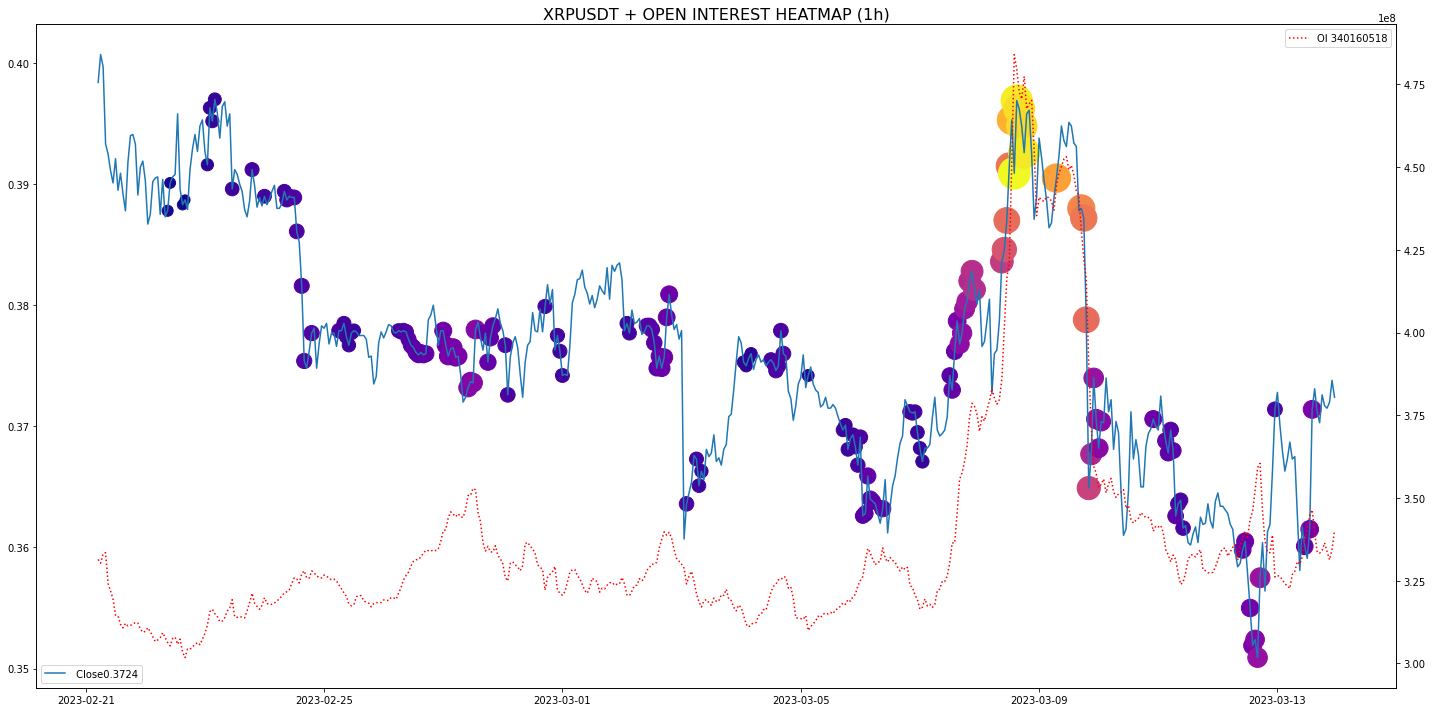

In [41]:
plt.rcParams['figure.figsize'] = (20,10)
fig, ax = plt.subplots()
ax.plot(df.index,df.Close,label=" Close"+str(round(last_close,decimal_rounding)))
# Ploteamos los circulos de colores. El tamaño de los circulos es funcion del sumOpenInterest
ax.scatter(x=filtered.index,y=filtered.Close,s=100+(norm_oi(filtered.sumOpenInterest)*900),c=filtered.sumOpenInterest,norm=norm_oi,cmap=cm.plasma)


plt.legend(loc='lower left')
# Ploteamos el OI en otro nuevo eje Y, con el mismo eje X
ax1 = ax.twinx()
ax1.plot(df.index,df.sumOpenInterest,color='r',linestyle=':',label="OI "+str(round(df.sumOpenInterest.tail(1).values[0])))
plt.legend(loc='upper right')
plt.title(symbol+" + OPEN INTEREST HEATMAP ("+str(timeframe)+")",fontsize=16)
plt.tight_layout()

Si te gustó y queres pasar por el canal de youtube para ver más como se fueron creando éstas funciones, y como seguirá el camino, te invito aqui: https://www.youtube.com/@rodrigoaprieto